In [3]:
import keras
import wandb
from wandb.keras import WandbCallback
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input
import groceries
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
(x_train, y_train_raw), (x_test, y_test_raw), class_names = groceries.load_data()

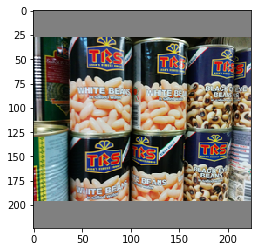

In [19]:
# take a look at the kinds of images we're dealing with
plt.imshow(x_train[0].astype(int))

In [21]:
# Print out the classes we need to target
class_names

['BEANS',
 'CAKE',
 'CANDY',
 'CEREAL',
 'CHIPS',
 'CHOCOLATE',
 'COFFEE',
 'CORN',
 'FISH',
 'FLOUR',
 'HONEY',
 'JAM',
 'JUICE',
 'MILK',
 'NUTS',
 'OIL',
 'PASTA',
 'RICE',
 'SODA',
 'SPICES',
 'SUGAR',
 'TEA',
 'TOMATO_SAUCE',
 'VINEGAR',
 'WATER']

(array([639., 439., 672., 199., 406., 602., 295., 504., 381., 560.]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <a list of 10 Patch objects>)

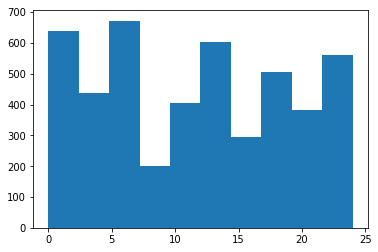

In [20]:
# check how balanced our class distribution is
plt.hist(y_train_raw)

In [5]:
# One hot encode ouput
y_train = keras.utils.to_categorical(y_train_raw)
y_test = keras.utils.to_categorical(y_test_raw)

In [6]:
# We build an extremely simple perceptron to try to fit our data

x_train_normalized = x_train / 255.
x_test_normalized = x_test / 255.

very_simple_model=Sequential()
very_simple_model.add(Flatten())
very_simple_model.add(Dense(25, activation="sigmoid"))
very_simple_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

wandb.init(project="transfer learn")
very_simple_model.fit(x_train_normalized, y_train, epochs=10, validation_data=(x_test_normalized, y_test), callbacks=[WandbCallback()])

W&B Run: https://app.wandb.ai/qualcomm/transfer learn/runs/axbldiyj
Call `%%wandb` in the cell containing your training loop to display live results.
Train on 4697 samples, validate on 250 samples
Epoch 1/10
2080/4697 [============>.................] - ETA: 3s - loss: 9.4750 - acc: 0.0240

KeyboardInterrupt: 

In [21]:
# Load ResNet50 Trained on imagenet
resnet_model = ResNet50(weights="imagenet")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [8]:
# We should preprocess the images the same way resnet images were preprocessed
x_train_preprocessed = preprocess_input(x_train)
x_test_preprocessed = preprocess_input(x_test)

In [24]:
# Build a new model that is ResNet50 minus the very last layer
last_layer = resnet_model.get_layer("avg_pool")

resnet_layers = keras.Model(inputs=resnet_model.inputs, outputs=last_layer.output)

In [7]:
# We use our resnet to "predict" but because we have removed the top layer, 
# this outputs the activations of the second to last layer on our dataset

x_train_features = resnet_layers.predict(x_train_preprocessed)

In [8]:
x_test_features = resnet_layers.predict(x_test_preprocessed)

In [24]:
finetune_model=Sequential()
finetune_model.add(Dense(25, activation="sigmoid"))
finetune_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [26]:
wandb.init(project="transfer learn")
finetune_model.fit(x_train_features, y_train, epochs=50, validation_data=(x_test_features, y_test), callbacks=[WandbCallback()])

W&B Run: https://app.wandb.ai/qualcomm/transfer learn/runs/qugw55sm
Call `%%wandb` in the cell containing your training loop to display live results.
Train on 4697 samples, validate on 250 samples
Epoch 1/50
4697/4697 [==============================] - 1s 115us/step - loss: 3.1553 - acc: 0.0296 - val_loss: 2.0266 - val_acc: 0.0400
Epoch 2/50
4697/4697 [==============================] - 1s 112us/step - loss: 1.5636 - acc: 0.0277 - val_loss: 1.7695 - val_acc: 0.0440
Epoch 3/50
4697/4697 [==============================] - 1s 113us/step - loss: 1.3147 - acc: 0.0324 - val_loss: 1.6685 - val_acc: 0.0560
Epoch 4/50
4697/4697 [==============================] - 1s 114us/step - loss: 0.9542 - acc: 0.3596 - val_loss: 0.9951 - val_acc: 0.6760
Epoch 5/50
4697/4697 [==============================] - 1s 114us/step - loss: 0.3309 - acc: 0.9046 - val_loss: 0.8222 - val_acc: 0.7400
Epoch 6/50
4697/4697 [==============================] - 1s 112us/step - loss: 0.2174 - acc: 0.9517 - val_loss: 0.8644 - val

In [25]:
# We can directly stich the models together

new_model=Sequential()
new_model.add(resnet_layers)
new_model.add(Dense(25, activation="sigmoid"))

new_model.layers[0].trainable=False

new_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 2048)              23587712  
_________________________________________________________________
dense_9 (Dense)              (None, 25)                51225     
Total params: 23,638,937
Trainable params: 51,225
Non-trainable params: 23,587,712
_________________________________________________________________


In [26]:
wandb.init(project="transfer learn")
new_model.fit(x_train_preprocessed, y_train, epochs=50, validation_data=(x_test_preprocessed, y_test), callbacks=[WandbCallback()])

W&B Run: https://app.wandb.ai/qualcomm/transfer learn/runs/fvj6hsbp
Call `%%wandb` in the cell containing your training loop to display live results.
Train on 4697 samples, validate on 250 samples
Epoch 1/50
4697/4697 [==============================] - 52s 11ms/step - loss: 1.7896 - acc: 0.4697 - val_loss: 2.0964 - val_acc: 0.3960
Epoch 2/50
4697/4697 [==============================] - 40s 9ms/step - loss: 0.7916 - acc: 0.7756 - val_loss: 1.8714 - val_acc: 0.4880
Epoch 3/50
4697/4697 [==============================] - 40s 9ms/step - loss: 0.5589 - acc: 0.8576 - val_loss: 1.9776 - val_acc: 0.4520
Epoch 4/50
4320/4697 [==========================>...] - ETA: 3s - loss: 0.4233 - acc: 0.8970

KeyboardInterrupt: 

In [ ]:
# We can allow some of the resnet layers to change as we train.  
# Typically you would want to lower the learning rate in conjunction with this.

new_model.layers[0].trainable = True

# We let the last 3 blocks train
for layer in new_model.layers[0].layers[:-11]:
    layer.trainable = False
for layer in new_model.layers[0].layers[-11:]:
    layer.trainable = True
    
new_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

wandb.init(project="transfer learn")
new_model.fit(x_train_preprocessed, y_train, epochs=50, validation_data=(x_test_preprocessed, y_test), callbacks=[WandbCallback()])

W&B Run: https://app.wandb.ai/qualcomm/transfer learn/runs/7dymajsj
Call `%%wandb` in the cell containing your training loop to display live results.
Train on 4697 samples, validate on 250 samples
Epoch 1/50
4697/4697 [==============================] - 60s 13ms/step - loss: 0.5584 - acc: 0.8350 - val_loss: 0.8870 - val_acc: 0.7320
Epoch 2/50
4697/4697 [==============================] - 47s 10ms/step - loss: 0.1907 - acc: 0.9461 - val_loss: 1.2564 - val_acc: 0.6680
Epoch 3/50
4697/4697 [==============================] - 47s 10ms/step - loss: 0.1000 - acc: 0.9745 - val_loss: 1.1069 - val_acc: 0.6800
Epoch 4/50
4697/4697 [==============================] - 47s 10ms/step - loss: 0.0670 - acc: 0.9842 - val_loss: 1.0718 - val_acc: 0.7000
Epoch 5/50
4697/4697 [==============================] - 47s 10ms/step - loss: 0.0496 - acc: 0.9881 - val_loss: 1.1851 - val_acc: 0.7200
Epoch 6/50
4697/4697 [==============================] - 47s 10ms/step - loss: 0.0352 - acc: 0.9908 - val_loss: 1.1626 - val